In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [5]:
sns.set(style="whitegrid")
df = pd.read_csv("options_KR.csv", parse_dates=["Date"], index_col="Date")
df["For_KOSPI_Netbuying_Amount"] = df["For_KOSPI_Netbuying_Amount"].apply(
    lambda x: int(float(x))
)
predictors = df.columns[1:].tolist()
df = pd.get_dummies(df, columns=["Day_of_a_week"])
predictors = df.columns[1:].tolist()

RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))


def split_time_dataset(X, y, train_ratio):
    assert X.shape[0] == len(y)

    n = X.shape[0]
    index = round(n * train_ratio)

    X_train, X_test = X.iloc[:index,], X.iloc[index:,]
    y_train, y_test = y[:index], y[index:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_time_dataset(df[predictors], df["VKOSPI"], 0.8)
RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

# Régression Ridge Et LASSO(avec régularisation)


Lasso Régression - Meilleur alpha selon RMSE: 22.56453846153846
Lasso Régression - Minimum RMSE: 2.3312811191204452


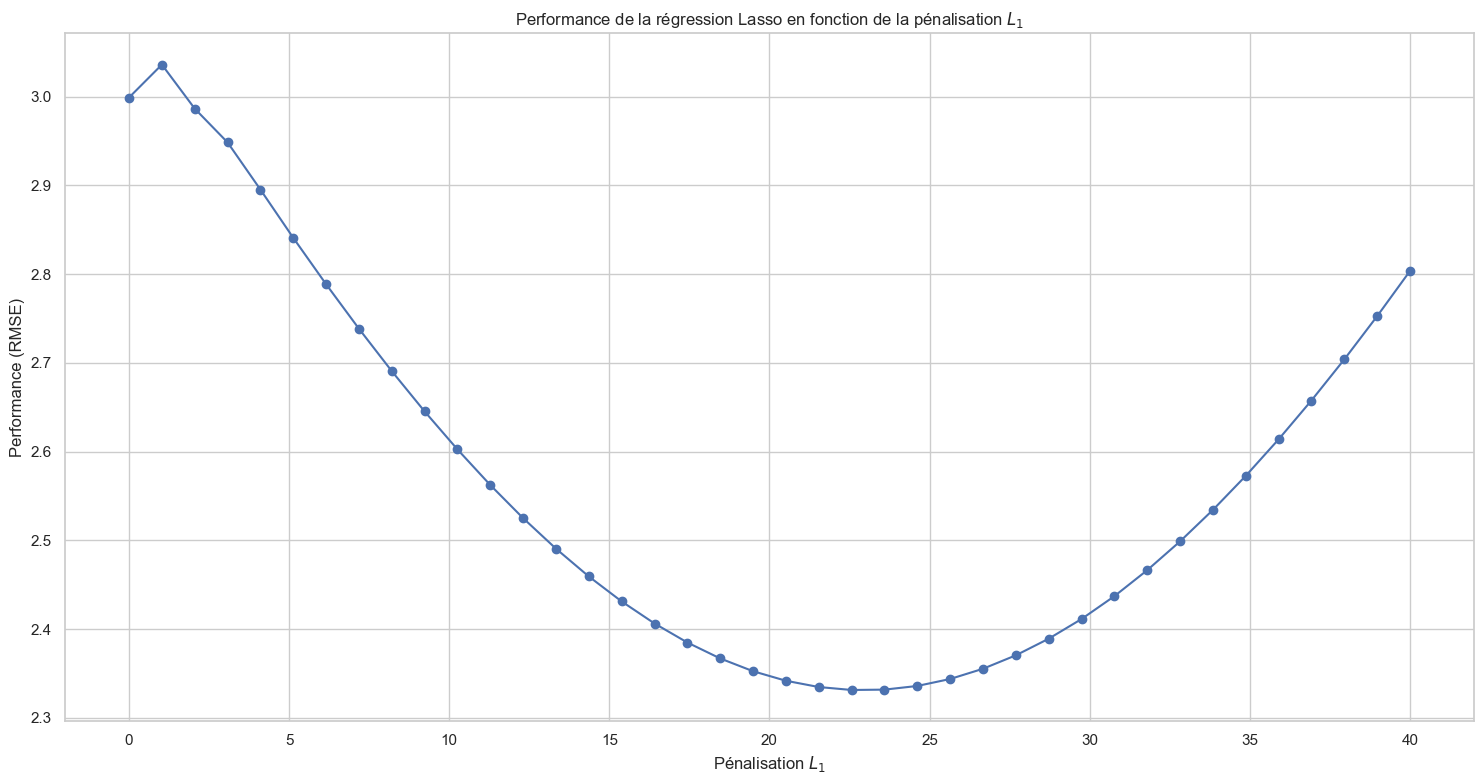

c:\Users\binhm\Projects\Predict_VKOSPI\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.09247e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\binhm\Projects\Predict_VKOSPI\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.27933e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\binhm\Projects\Predict_VKOSPI\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.45479e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\binhm\Projects\Predict_VKOSPI\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.1813e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True)

Ridge Régression - Meilleur alpha selon RMSE: 5.129076923076924
Ridge Régression - Minimum RMSE: 2.998706518503766


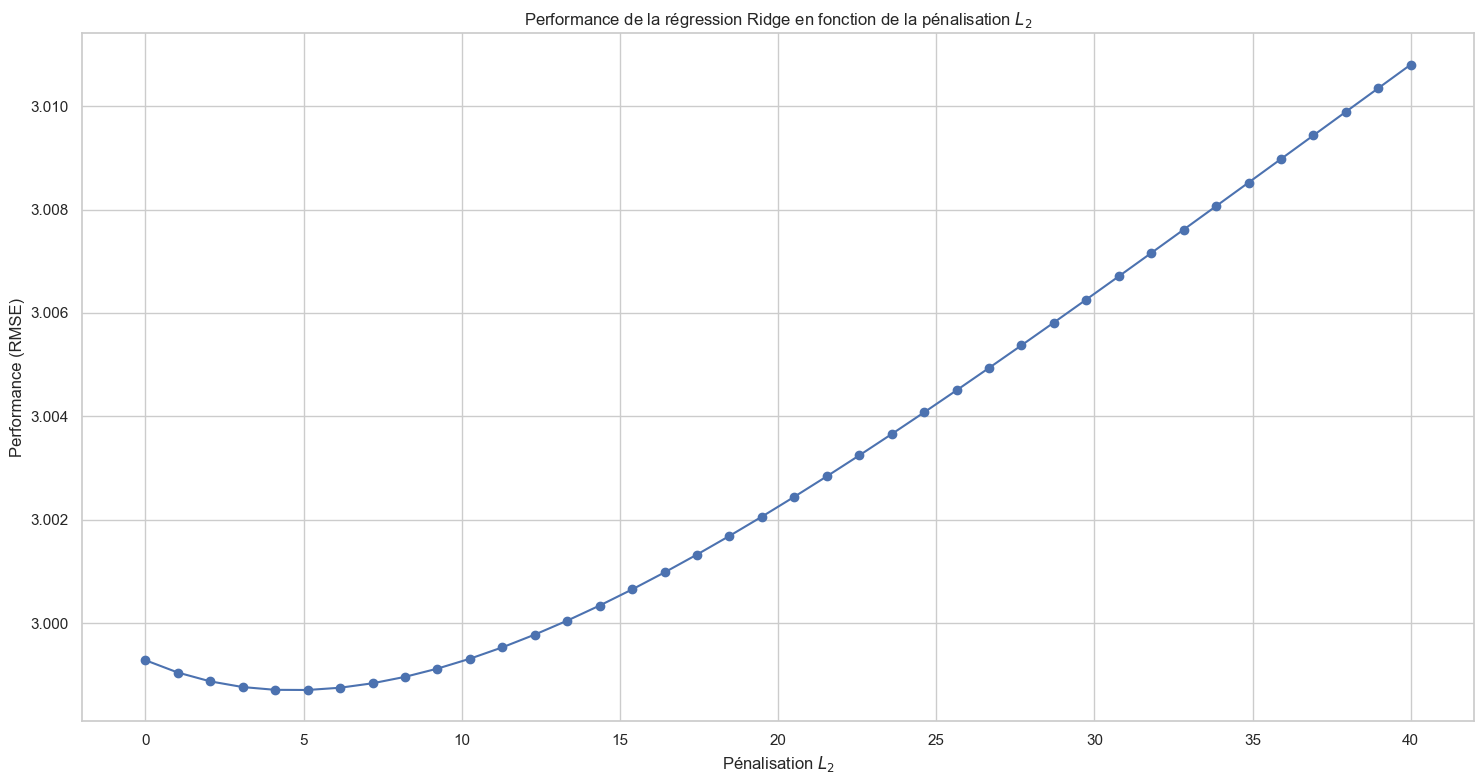

In [6]:
def find_best_alpha(model_type, X_train, y_train, X_test, y_test, alpha_grid):
    if model_type not in ["lasso", "ridge"]:
        raise ValueError("model_type doit être 'lasso' ou 'ridge'")

    rmse_result = []

    for alpha in alpha_grid:
        if model_type == "lasso":
            model = Lasso(alpha=alpha)
            penalty_type = "$L_1$"
        elif model_type == "ridge":
            model = Ridge(alpha=alpha)
            penalty_type = "$L_2$"

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_result.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        # r2_result.append(r2_score(y_test, y_pred))

    min_index_RMSE = np.argmin(rmse_result)
    best_alpha_RMSE = alpha_grid[min_index_RMSE]

    print(
        f"{model_type.capitalize()} Régression - Meilleur alpha selon RMSE: {best_alpha_RMSE}"
    )
    print(
        f"{model_type.capitalize()} Régression - Minimum RMSE: {rmse_result[min_index_RMSE]}"
    )

    # max_index_R2 = np.argmax(r2_result)
    # best_alpha_R2 = alpha_grid[max_index_R2]
    # print(f"{model_type.capitalize()} Régression - Meilleur alpha selon R²: {best_alpha_R2}")
    # print(f"{model_type.capitalize()} Régression - Maximum R²: {r2_result[max_index_R2]}")

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 1, 1)
    plt.plot(alpha_grid, rmse_result, "o-")
    plt.xlabel(f"Pénalisation {penalty_type}")
    plt.ylabel("Performance (RMSE)")
    plt.title(
        f"Performance de la régression {model_type.capitalize()} en fonction de la pénalisation {penalty_type}"
    )

    # Graphique pour le R² (désactivé)
    # plt.subplot(1, 2, 2)
    # plt.plot(alpha_grid, r2_result, 'o-')
    # plt.xlabel(f"Pénalisation {penalty_type}")
    # plt.ylabel("Performance (R²)")
    # plt.title(f"Performance de la régression {model_type.capitalize()} en fonction de la pénalisation {penalty_type}")

    plt.tight_layout()
    plt.show()

    return best_alpha_RMSE


alpha_grid = np.linspace(0.001, 40, 40)

best_alpha_lasso = find_best_alpha(
    "lasso", X_train, y_train, X_test, y_test, alpha_grid
)

best_alpha_ridge = find_best_alpha(
    "ridge", X_train, y_train, X_test, y_test, alpha_grid
)

# Régression ElasticNet et recherche par grille


### Grâce au code précédent, nous avons trouvé les meilleures valeurs de alpha pour Lasso et Ridge. Nous pouvons utiliser ces résultats pour guider le réglage des paramètres d'ElasticNet, en commençant la recherche autour de la Moyen des valeurs de alpha pour Lasso et Ridge. Comme le RMSE optimal de Lasso est inférieur à celui de Ridge, nous allons fixer la valeur de l1_ratio à un niveau superieur à 0,5, afin de donner une plus grande importance à Lasso dans le modèle ElasticNet.


ElasticNet - Meilleur alpha: 25.506788621042162
ElasticNet - Meilleur l1_ratio: 0.8888888888888888
ElasticNet - Minimum RMSE: 2.331063476324688


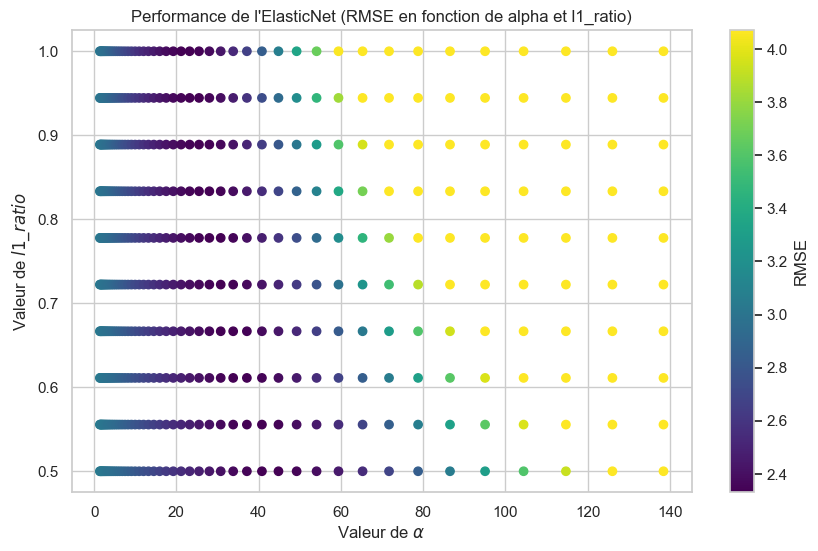

In [ ]:
def optimize_elasticnet(X_train, y_train, X_test, y_test, lasso_alpha, ridge_alpha):
    # 使用 Lasso 和 Ridge 的 alpha 平均值作为 ElasticNet 的初始 alpha
    initial_alpha = (lasso_alpha + ridge_alpha) / 2
    if initial_alpha <= 0:
        raise ValueError("Initial alpha must be greater than 0.")
    log_initial_alpha = max(np.log10(initial_alpha), -3)
    alpha_grid = np.logspace(log_initial_alpha - 1, log_initial_alpha + 1, 50)

    l1_ratios = np.linspace(0.5, 1.0, 10)
    rmse_results = []
    best_rmse = float("inf")
    best_alpha = None
    best_l1_ratio = None

    for l1_ratio in l1_ratios:
        for alpha in alpha_grid:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            rmse_results.append((alpha, l1_ratio, rmse))
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
                best_l1_ratio = l1_ratio

    print(f"ElasticNet - Meilleur alpha: {best_alpha}")
    print(f"ElasticNet - Meilleur l1_ratio: {best_l1_ratio}")
    print(f"ElasticNet - Minimum RMSE: {best_rmse}")

    alphas = [result[0] for result in rmse_results]
    l1_ratios = [result[1] for result in rmse_results]
    rmses = [result[2] for result in rmse_results]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(alphas, l1_ratios, c=rmses, cmap="viridis")
    plt.colorbar(scatter, label="RMSE")
    plt.xlabel(r"Valeur de $\alpha$")
    plt.ylabel(r"Valeur de $l1\_ratio$")
    plt.title("Performance de l'ElasticNet (RMSE en fonction de alpha et l1_ratio)")
    plt.show()

    return best_alpha, best_l1_ratio


# alpha_grid = np.logspace(-4, 1, 50)
best_elasticnet_alpha, best_elasticnet_l1_ratio = optimize_elasticnet(
    X_train, y_train, X_test, y_test, best_alpha_lasso, best_alpha_ridge
)

Conclusion : Nous avons finalement constaté que l'utilisation du modèle de régression ElasticNet sur des données non nettoyées est moins performante que l'utilisation du modèle Lasso seul. Cela indique que nos données actuelles, non nettoyées, contiennent des variables non pertinentes qui n'ont pas été éliminées.


# Régressions polynomiales (en train de réfléchir)


Degree: 1, RMSE: 3.1527
Degree: 2, RMSE: 4.2794
Degree: 3, RMSE: 3.9198
Degree: 4, RMSE: 4.0027
Degree: 5, RMSE: 4.0084


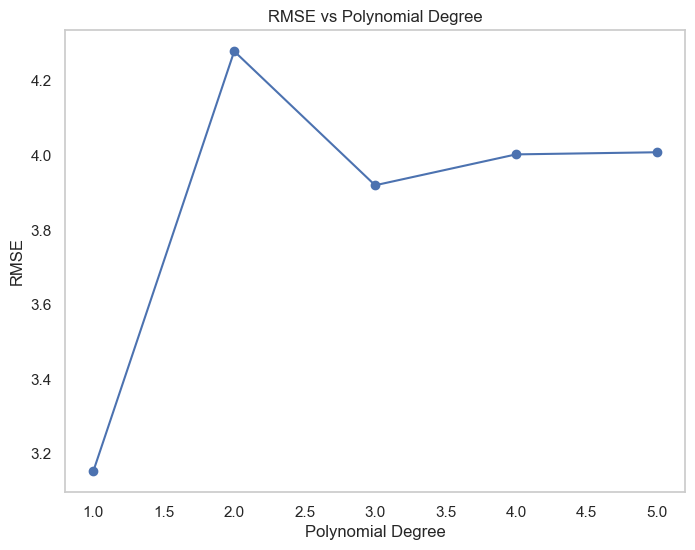

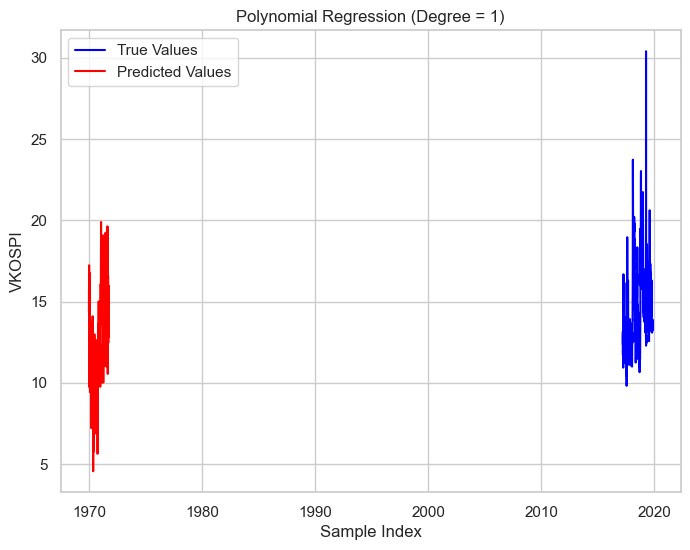

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def polynomial_regression(X_train, y_train, X_test, y_test, max_degree):
    results = []

    for degree in range(1, max_degree + 1):

        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append((degree, rmse))

        print(f"Degree: {degree}, RMSE: {rmse:.4f}")

    return results


max_degree = 5
results = polynomial_regression(X_train, y_train, X_test, y_test, max_degree)

degrees, rmses = zip(*results)
plt.figure(figsize=(8, 6))
plt.plot(degrees, rmses, marker="o")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.grid()
plt.show()


best_degree = min(results, key=lambda x: x[1])[0]
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


best_model = LinearRegression()
best_model.fit(X_train_poly, y_train)


y_pred = best_model.predict(X_test_poly)
plt.figure(figsize=(8, 6))
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_pred, label="Predicted Values", color="red")
plt.title(f"Polynomial Regression (Degree = {best_degree})")
plt.xlabel("Sample Index")
plt.ylabel("VKOSPI")
plt.legend()
plt.show()